In [1]:
# Download capital bikeshare sample data
#just the imports
import pandas as pd
import urllib.request #modification from tutorial for python 3
import tempfile
import shutil
import zipfile

In [2]:
#download zipfile and unpack
temp_dir = tempfile.mkdtemp()
data_source = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
zipname = temp_dir + '/Bike-Sharing-Dataset.zip'
print(zipname)
urllib.request.urlretrieve(data_source, zipname) #modification from tutorial for python 3; puts resource at first argument into file location in second argument

zip_ref = zipfile.ZipFile(zipname, 'r')
zip_ref.extractall(temp_dir)
zip_ref.close()

C:\Users\SullivKF\AppData\Local\Temp\tmprog8_bne/Bike-Sharing-Dataset.zip


In [3]:
#zipfile contains "day" and "hour" csv files, plus a readme
#read the day.csv file into a pandas dataframe 
daily_path = temp_dir +'/day.csv' #not sure this step is necessary
daily_data = pd.read_csv(daily_path)
daily_data['dteday'] = pd.to_datetime(daily_data['dteday'])
daily_data.head() #check the initial raw data

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [ ]:
#original tutorial drops a bunch of varaibles.
#i'm not sure I'd do that
drop_list = ['instant', 'season', 'yr', 'mnth', 'holiday', 'workingday', 'weathersit', 'atemp', 'hum']
daily_data.drop(drop_list, inplace = True, axis = 1)

#delete the temp directory
shutil.rmtree(temp_dir)

In [6]:
#graphing imports
from __future__ import division, print_function
from matplotlib import pyplot as plt
import numpy as np #pandas already imported
#shows plots inline in notebook - note apparently you can't put a comment after a % command
%matplotlib inline 

In [7]:
#Parameters to apply to all plots
import matplotlib
#Plot size to 14" x 7"
matplotlib.rc('figure', figsize = (14, 7))
#Font size to 14
matplotlib.rc('font', size = 14)
#Do not display top and right frame lines
matplotlib.rc('axes.spines', top = False, right = False)
#Remove grid lines
matplotlib.rc('axes', grid = False)
#Set background color to white
matplotlib.rc('axes', facecolor = 'white')

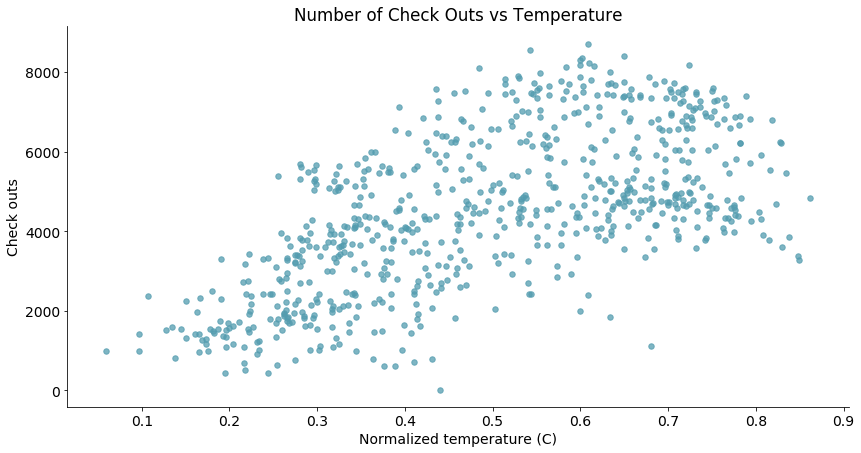

In [10]:
#Define a custom scatterplot function
def scatterplot(x_data, y_data, x_label, y_label, title):
    #Create the plot object - underscore used to ignore figure name on left side of expression
    _, ax = plt.subplots()
    
    #Plot the data, set the size (x), color and transparency (alpha) of the points
    ax.scatter(x_data, y_data, s=30, color = '#539caf', alpha = 0.75)
    
    #Label the axes and provide a title
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

#test out the function
scatterplot(x_data = daily_data['temp']
          , y_data = daily_data['cnt']
          , x_label = 'Normalized temperature (C)'
          , y_label = 'Check outs'
          , title = 'Number of Check Outs vs Temperature')
    
    

## Fit a linear model to the Temp - Checkout data
(note, doesn't look all that linear to me - maybe in two regimes:above and then below 0.6)

The tutorial uses statsmodels (which I had to install from the precompiled whl).
Statsmodels syntax is not intutive to me. I would expect to send the OLS function an X (independent var or matrix of independent vars) and a y (dependent var) and have it figure out the constant per y ~ B1X + B0. Statsmodel's OLS function seems to want the constant B0 specified in the input matrix X. The add_constant function just [pre/a]ppends a column of ones to the input matrix to give the OLS function something to calculate on to get B0.
Let's check:

In [14]:
#imports only
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

In [27]:
#check this add constant business:  raw 'design' matrix (or column in our case)
x = daily_data['temp']
print(x.head())

0    0.344167
1    0.363478
2    0.196364
3    0.200000
4    0.226957
Name: temp, dtype: float64


In [23]:
x = sm.add_constant(daily_data['temp'])
print(x.head())

   const      temp
0    1.0  0.344167
1    1.0  0.363478
2    1.0  0.196364
3    1.0  0.200000
4    1.0  0.226957


... Ok, fine. If that's the format statsmodels wants, that's the foramt statsmodels gets.

In [30]:
#setup and run ols model
x = sm.add_constant(daily_data['temp'])
y = daily_data['cnt']
regr = sm.OLS(y,x) #sets up the model
res = regr.fit() #runs the model - returns an OLS_Regression object
print(res.summary()) #show model summary results - similar to R output

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     473.5
Date:                Wed, 19 Jul 2017   Prob (F-statistic):           2.81e-81
Time:                        11:59:55   Log-Likelihood:                -6386.8
No. Observations:                 731   AIC:                         1.278e+04
Df Residuals:                     729   BIC:                         1.279e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1214.6421    161.164      7.537      0.0

Note the coefficient fit is good in the sense that the Pvalue is < 0.001, but this model doesn't have much explanatory power: the R-squared is ~ 0.4. As I noted above, I'm not sure a linear model is the right choice here, but I guess it illustrates one approach to exploring a dataset.

In the next cell we extract a fitted curve to use in our line plot.
I can get the ordered fitted values as a pandas object (I think) straight from res, but later we'll need the confidence interval for each fitted point - that's why we're bringing the summary_table function into this.

BTW, why is the summary_table function under **outliers_influence** (see import cell above)? Google has yet to find me a good answer.

In [58]:
#what can I get from the fitted results object?
print('coefficients:\n', res.params)
print('\ncoefficient confidence intervals:\n', res.conf_int(alpha=0.05))
print('\npvalues:\n', res.pvalues)
print('\nfitted values:\n', res.fittedvalues.head())

coefficients:
 const    1214.642119
temp     6640.709999
dtype: float64

coefficient confidence intervals:
                  0            1
const   898.242096  1531.042142
temp   6041.557701  7239.862296

pvalues:
 const    1.432673e-13
temp     2.810622e-81
dtype: float64

fitted values:
 0    3500.155357
1    3628.394108
2    2518.638497
3    2542.784119
4    2721.797738
dtype: float64


In [56]:
#get fitted values to plot - version from the original tutorial
st, data, ss2 = summary_table(res, alpha=0.05)
fitted_values = data[:, 2]
print(fitted_values)

[ 3500.1553571   3628.39410788  2518.63849718  2542.78411874  2721.79773817
  2571.65792581  2519.68772936  2310.35926879  2133.27145526  2216.28033024
  2337.52641339  2361.67203495  2310.35926879  2282.9331365   2764.13890512
  2753.07548226  2382.2980802   2653.46483228  3154.88492215  2952.29678222
  2393.36814377  1607.30995753  1855.6147373   1861.38949871  2698.69470809
  2658.99654371  2509.58056875  2565.88050811  2519.68772936  2652.50192934
  2415.5016302   2490.81392229  2941.22671865  2456.16933823  2617.85070456
  2764.13890512  3112.77618004  3018.70388221  2681.13003014  2109.69693476
  2173.2153259   2470.34061336  2692.20009371  3316.57292919  3970.53676843
  2981.64872041  3328.12112388  4108.88267983  4678.88138184  3865.39440702
  3108.68550269  3228.98860502  2424.72557638  2687.1465134   3177.98131152
  3634.17152558  3090.64269362  3495.57990791  3919.22400227  2985.50033221
  3439.27996854  2531.71405517  2952.29678222  3765.78375704  3715.0155291
  2952.774913

In [62]:
#setup the lineplot function - almost identical to the scatterplot function
def lineplot(x_data, y_data, x_label, y_label, title):
    #Create the plot object - underscore used to ignore figure name on left side of expression
    _, ax = plt.subplots()
    
    #Plot the data, set the size (x), color and transparency (alpha) of the points
    ax.plot(x_data, y_data, lw=2, color = '#539caf', alpha = 1)
    
    #Label the axes and provide a title
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

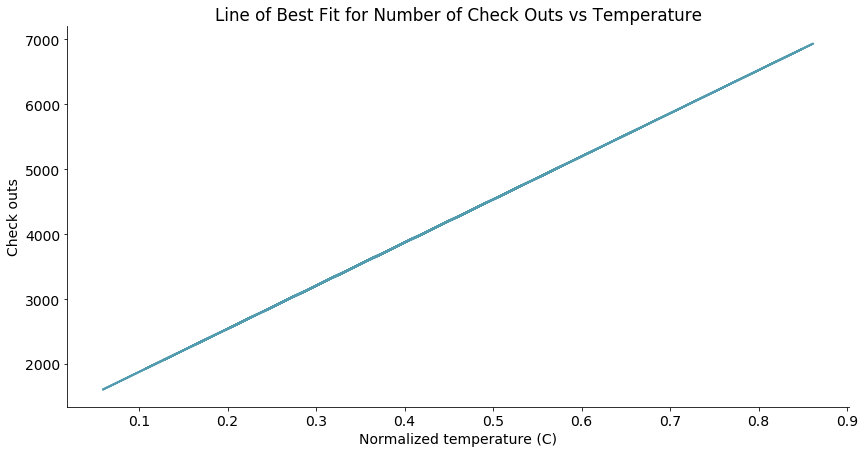

In [65]:
#draw the fitted line
lineplot(x_data=daily_data['temp']
        , y_data = fitted_values
        , x_label = 'Normalized temperature (C)'
        , y_label = 'Check outs'
        , title = 'Line of Best Fit for Number of Check Outs vs Temperature')

## The Seaborn way
I'd really prefer to see this line overlayed on top of the original scatter plot. Turns out I should be able to do that, and show the confidence interval with one line of code in seaborn:

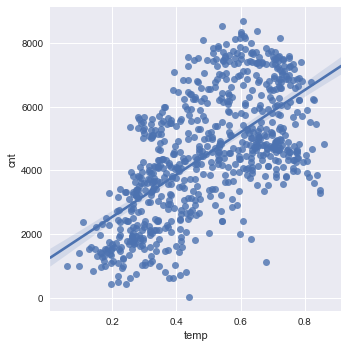

In [66]:
import seaborn as sns
sns.lmplot(x='temp', y='cnt', data=daily_data)

Holy cow, that's easier!
(Remarkably, Seaborn doesn't have just a scatter plot function, but you can take the regression line off using fit_reg=False. See https://elitedatascience.com/python-seaborn-tutorial)